In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [2]:
data = pd.read_csv('hw_aa.csv', sep=';', index_col='Unnamed: 0')

In [3]:
data

,uid,experimentVariant,version,purchase
1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0
...,...,...,...,...
127014,d1f082ede77b17a99a9b0b240daf7bdf,0,v2.8.0,0
127015,94f0d540830ccdc6b29c1938eea445cc,0,v2.8.0,0
127016,709f74cf9721328e98be6f216e8a05a8,1,v2.9.0,0
127017,1767ae3f8ffec269d9ed0ac0ede68d90,1,v2.8.0,0


### Задача
Запустите A/A-тест. Посчитайте FPR на уровне альфа = 0.05 

Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента


In [4]:
# group by experimentVariant and version and how much people on each version
data.groupby(['version', 'experimentVariant',], as_index = False).agg({'purchase' : 'mean', 'uid':'count'})

# оказалось, что аномалия в версии 2.8.0, в которой конверсия сильно различается
# проверим p-value

,version,experimentVariant,purchase,uid
0,v2.8.0,0,0.000993,41283
1,v2.8.0,1,0.045606,41552
2,v2.9.0,0,0.074658,11921
3,v2.9.0,1,0.071304,12033
4,v3.7.4.0,0,0.059943,4204
5,v3.7.4.0,1,0.063018,4221
6,v3.8.0.0,0,0.057604,5694
7,v3.8.0.0,1,0.062848,6110


In [5]:
# проверка p-value для всех версий
for element in set(data.version):
    ttest = stats.ttest_ind(data[(data.experimentVariant == 0) & (data.version == element)].purchase, 
                           data[(data.experimentVariant == 1) & (data.version == element)].purchase,
                           equal_var = False)
    print(ttest)

Ttest_indResult(statistic=-1.1973368830477649, pvalue=0.2311993431794881)
Ttest_indResult(statistic=-0.5875202960070302, pvalue=0.5568700784122844)
Ttest_indResult(statistic=-43.097051598551076, pvalue=0.0)
Ttest_indResult(statistic=0.997860971925487, pvalue=0.31835686930247525)


In [6]:
# исходя из полученных выше результатов, принимаем решение выкинуть версию с явной аномалией для 
# проведения А/А-теста

In [7]:
df = data.query('version != "v2.8.0"')
df

,uid,experimentVariant,version,purchase
2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
7,8f14e45fceea167a5a36dedd4bea2543,0,v2.9.0,0
11,6512bd43d9caa6e02c990b0a82652dca,1,v2.9.0,0
14,aab3238922bcc25a6f606eb525ffdc56,1,v2.9.0,0
...,...,...,...,...
126995,3e3eeaa665b7d18d1146aa4e654d62b5,0,v2.9.0,0
126997,6f8ce2ea30ba2d0972dd0384f6635a44,0,v2.9.0,0
127003,970f71ac90be02ba17f2085ef0086391,0,v2.9.0,0
127004,0e671d3fc3d37c7e956765f06026171b,1,v2.9.0,0


In [8]:
# строим А/А-симуляцию

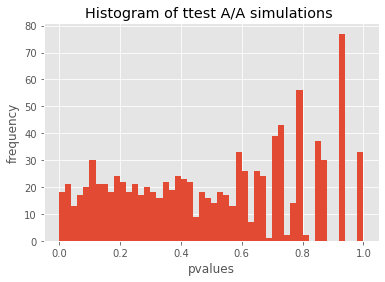

0.044

In [12]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 0)].purchase.sample(n_s, replace=False).values
    s2 = df[(df.experimentVariant == 1)].purchase.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

## Исходя из полученного значение FPR = 0.044 < 0.05, понимаем, что исключили поломку. Задача решена.
#### Ниже расчет без исключения аномалии.  FPR = 0.938 > 0.05

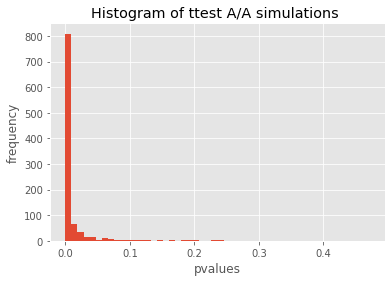

0.938

In [13]:
n = 100000
simulations = 1000
n_s = 1000
res = []


# Запуск симуляций A/A теста
for i in tqdm(range(simulations)):
    s1 = data[(data.experimentVariant == 0)].purchase.sample(n_s, replace=False).values
    s2 = data[(data.experimentVariant == 1)].purchase.sample(n_s, replace=False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations ")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations